In [1]:
import numpy as np
from shapely.geometry import Polygon, LineString
import matplotlib.pyplot as plt

# Generate racks, obstacles, and depot position
def generate_rack_layout(rows, cols, rack_width=1000, rack_height=4000, walkway_width=2000):
    """
    Generates a grid of racks and vertices for the layout.
    :param rows: Number of rows
    :param cols: Number of columns
    :param rack_width: Width of each rack in mm
    :param rack_height: Height of each rack in mm
    :param walkway_width: Width of walkways between racks
    :return: (list of polygons representing racks, N-by-2 array of vertices)
    """
    rack_polygons = []
    vertices = []

    for row in range(rows):
        for col in range(cols):
            x_start = col * (rack_width + walkway_width)
            y_start = row * (rack_height + walkway_width)

            # Create a rack polygon
            rack_polygon = Polygon([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])
            rack_polygons.append(rack_polygon)

            # Add vertices for the rack
            vertices.extend([
                (x_start, y_start),  # Bottom-left
                (x_start, y_start + rack_height),  # Top-left
                (x_start + rack_width, y_start + rack_height),  # Top-right
                (x_start + rack_width, y_start)  # Bottom-right
            ])

    return rack_polygons, np.array(vertices)


def add_picker_depot(vertices, depot_x=0, depot_y=-2000):
    """
    Adds a picker depot to the vertices.
    :param vertices: Array of vertices
    :param depot_x: X-coordinate of the depot
    :param depot_y: Y-coordinate of the depot
    :return: Updated vertices, depot coordinates
    """
    depot = (depot_x, depot_y)
    vertices = np.vstack([vertices, depot])  # Add depot to vertex array
    return vertices, depot


def generate_dummy_obstacles(vertices, path_width=1200):
    """
    Generates dummy obstacles for narrow paths.
    :param vertices: Array of vertices
    :param path_width: Minimum allowed path width
    :return: List of dummy obstacle polygons
    """
    dummy_obstacles = []
    for i in range(0, len(vertices), 2):  # Pairwise vertices
        x1, y1 = vertices[i]
        x2, y2 = vertices[i + 1] if i + 1 < len(vertices) else (x1, y1)

        # Create dummy obstacles for narrow gaps
        if abs(x2 - x1) < path_width or abs(y2 - y1) < path_width:
            obstacle = Polygon([
                (x1 - path_width / 2, y1 - path_width / 2),
                (x1 + path_width / 2, y1 - path_width / 2),
                (x1 + path_width / 2, y1 + path_width / 2),
                (x1 - path_width / 2, y1 + path_width / 2)
            ])
            dummy_obstacles.append(obstacle)
    return dummy_obstacles


ModuleNotFoundError: No module named 'numpy'

In [2]:
def generate_adjacency_matrix(vertices, polygons):
    """
    Generates the adjacency matrix for vertices considering obstructing polygons.
    :param vertices: Array of vertices
    :param polygons: List of polygons (obstacles)
    :return: Adjacency matrix (N-by-N binary matrix)
    """
    N = len(vertices)
    adjMat = np.ones((N, N), dtype=int)  # Start with all connections allowed

    for i in range(N):
        for j in range(i + 1, N):
            if i != j:
                line = LineString([vertices[i], vertices[j]])  # Line segment

                # Check if the line intersects any polygon
                for poly in polygons:
                    if line.intersects(poly):
                        adjMat[i, j] = 0
                        adjMat[j, i] = 0
                        break  # No need to check further polygons

    return adjMat


In [3]:
def visualize_layout(vertices, polygons, adjMat, depot):
    """
    Visualizes the layout, depot, and valid edges.
    :param vertices: Array of vertices
    :param polygons: List of polygons (racks and obstacles)
    :param adjMat: Adjacency matrix
    :param depot: Coordinates of the picker depot
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot polygons
    for poly in polygons:
        x, y = poly.exterior.xy
        ax.fill(x, y, alpha=0.5, fc='red', ec='black', label='Rack/Obstacle')

    # Plot vertices
    for idx, (x, y) in enumerate(vertices):
        if (x, y) == depot:
            ax.plot(x, y, 'go', markersize=10, label='Picker Depot')  # Depot in green
        else:
            ax.plot(x, y, 'bo')  # Other vertices in blue

    # Plot edges based on adjacency matrix
    N = len(vertices)
    for i in range(N):
        for j in range(i + 1, N):
            if adjMat[i, j] == 1:
                x_coords = [vertices[i][0], vertices[j][0]]
                y_coords = [vertices[i][1], vertices[j][1]]
                ax.plot(x_coords, y_coords, 'g-')  # Valid path

    plt.title("Warehouse Layout with Valid Paths and Depot")
    plt.xlabel("X (mm)")
    plt.ylabel("Y (mm)")
    plt.legend(loc='upper right')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()


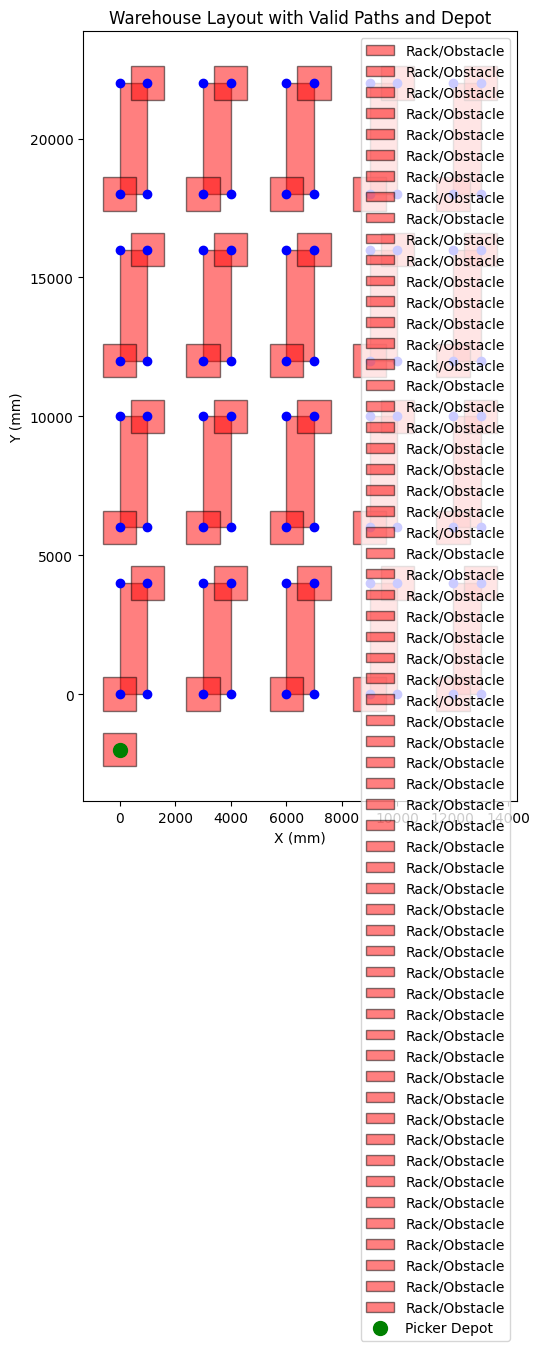

In [4]:
# Parameters
rows = 4
cols = 5
rack_width = 1000
rack_height = 4000
walkway_width = 2000
path_width = 1200  # Minimum path width

# Generate racks and vertices
rack_polygons, vertices = generate_rack_layout(rows, cols, rack_width, rack_height, walkway_width)

# Add depot
vertices, depot = add_picker_depot(vertices)

# Generate dummy obstacles
dummy_obstacles = generate_dummy_obstacles(vertices, path_width)

# Combine all polygons
all_polygons = rack_polygons + dummy_obstacles

# Generate adjacency matrix
adjMat = generate_adjacency_matrix(vertices, all_polygons)

# Visualize the layout
visualize_layout(vertices, all_polygons, adjMat, depot)
